# 📊 Predicting 2024/25 Premier League Win Probabilities Based on 2023/24 Data


This estimates the win probabilities for Premier League teams in the **2024/25 season**, using their performance in the **2023/24 season**.

I assumed that each team's win behavior follows a **Bernoulli distribution**, and use a **Binomial model** to estimate the likelihood of winning a given number of games in the next season.


In [ ]:
# to import libraries
import requests
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Setting the API Parameters
API_KEY = 'a98db8dfe04d29cbb45dbb09c2d6f8bb'
BASE_URL = 'https://v3.football.api-sports.io'
HEADERS = {'x-apisports-key': API_KEY}

league_id = 39  # Premier League
season = 2023   # Use last season to build prediction


In [ ]:
# to get the Premier League 2023/2024 Season Fixtures:
params = {'league': league_id, 'season': season}
response = requests.get(f'{BASE_URL}/fixtures', headers=HEADERS, params=params)
fixtures = response.json()['response']
print(f"Fixtures found: {len(fixtures)}")


Fixtures found: 380


In [ ]:
# to build the results DataFrame
# by extracting the winners only from matches that are complete (FT).
matches = []
for match in fixtures:
    if match['fixture']['status']['short'] == 'FT':
        home = match['teams']['home']['name']
        away = match['teams']['away']['name']
        winner = match['teams']['home']['winner']
        if winner is None:
            result = 'Draw'
        elif winner:
            result = home
        else:
            result = away
        matches.append({'home': home, 'away': away, 'winner': result})

df = pd.DataFrame(matches)
df.head()


,home,away,winner
0,Burnley,Manchester City,Manchester City
1,Arsenal,Nottingham Forest,Arsenal
2,Bournemouth,West Ham,Draw
3,Everton,Fulham,Fulham
4,Brighton,Luton,Brighton


In [8]:
# To Count the wins & matches per Team

# list all unique teams:
teams = pd.unique(df[['home', 'away']].values.ravel())

#this initializes win and match counters
team_wins = {team: 0 for team in teams}
team_matches = {team: 0 for team in teams}

#to count the wins & total matches:
for _, row in df.iterrows():
    if row['winner'] != 'Draw':
        team_wins[row['winner']] += 1
    team_matches[row['home']] += 1
    team_matches[row['away']] += 1

# To create a Dataframe for win stats:
win_df = pd.DataFrame({
    'Team': list(teams),
    'Wins': [team_wins[t] for t in teams],
    'Matches': [team_matches[t] for t in teams]
})

# To calculate win probabilities in Bernoulli:
win_df['Historical_Win_Prob'] = win_df['Wins'] / win_df['Matches']
win_df.sort_values(by='Historical_Win_Prob', ascending=False, inplace=True)
win_df.reset_index(drop=True, inplace=True)
win_df.head()


,Team,Wins,Matches,Historical_Win_Prob
0,Manchester City,28,38,0.736842
1,Arsenal,28,38,0.736842
2,Liverpool,24,38,0.631579
3,Tottenham,20,38,0.526316
4,Aston Villa,20,38,0.526316


## 📈 Predicting Win Outcomes for 2024/25 Season (Based on 2023/24 Win Rates)

In [ ]:
# assume a 38 game season
n = 38  # total matches in a season
k = 20  # threshold for high performance : target to win 20 or more games

# A function created to calculate P(X ≥ k)
def predict_next_season_win_prob(team_name, k, n):
    p = win_df[win_df['Team'] == team_name]['Historical_Win_Prob'].values[0]
    return 1 - binom.cdf(k - 1, n, p)

# To add a new column for the probability
win_df[f'P(Win ≥ {k}/{n})_Predicted'] = win_df['Team'].apply(lambda t: predict_next_season_win_prob(t, k, n))
win_df[['Team', 'Wins', 'Matches', 'Historical_Win_Prob', f'P(Win ≥ {k}/{n})_Predicted']]


,Team,Wins,Matches,Historical_Win_Prob,P(Win ≥ 20/38)_Predicted
0,Manchester City,28,38,0.736842,9.984756e-01
1,Arsenal,28,38,0.736842,9.984756e-01
2,Liverpool,24,38,0.631579,9.331216e-01
3,Tottenham,20,38,0.526316,5.654862e-01
4,Aston Villa,20,38,0.526316,5.654862e-01
5,Chelsea,18,38,0.473684,3.125301e-01
6,Newcastle,18,38,0.473684,3.125301e-01
7,Manchester United,18,38,0.473684,3.125301e-01
8,West Ham,14,38,0.368421,3.399319e-02
9,Crystal Palace,13,38,0.342105,1.483543e-02


C:\Users\Loryne\AppData\Local\Temp\ipykernel_34812\1911727344.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Historical_Win_Prob', y='Team', data=win_df, palette='crest')


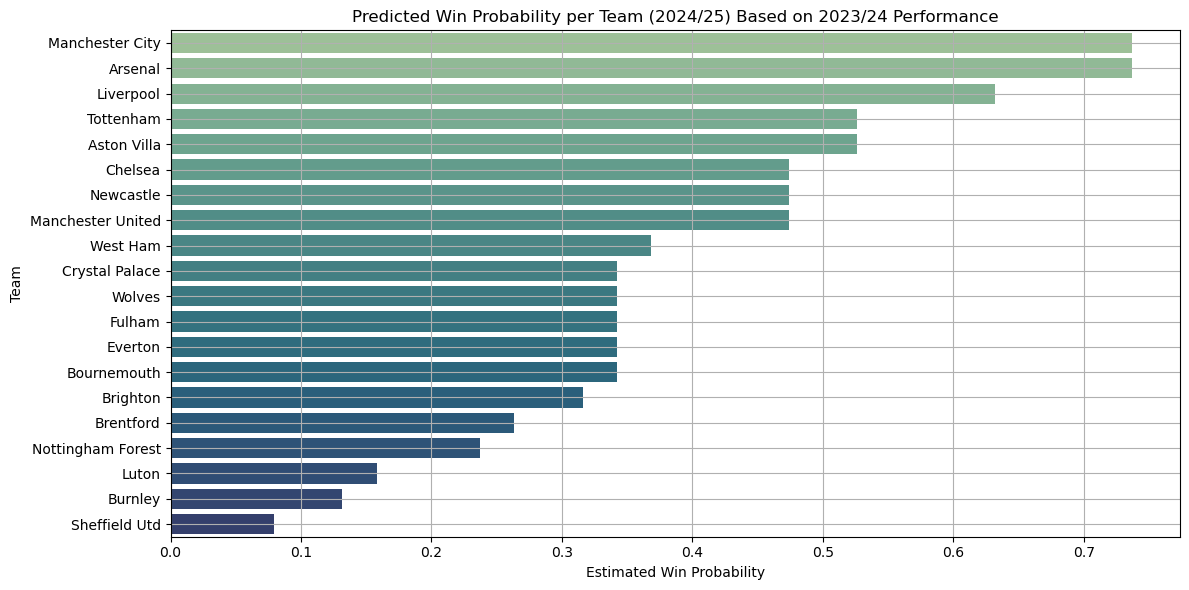

In [ ]:
# To visualize the Win Probabilities (Seaborn & Matplotlib):

plt.figure(figsize=(12, 6))
sns.barplot(x='Historical_Win_Prob', y='Team', data=win_df, palette='crest')
plt.title('Predicted Win Probability per Team (2024/25) Based on 2023/24 Performance')
plt.xlabel('Estimated Win Probability')
plt.ylabel('Team')
plt.grid(True)
plt.tight_layout()
plt.show()



---

### ✅ Summary
- Win_Probability shows past performance (how often they win).

- P(Win ≥ 20/38) predicts how likely they are to win 20+ games in a season, based on a Binomial model.

- I used historical match results from 2023/24 to estimate win probabilities for the 2024/25 season.

